In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

CSV_PATH = r"C:\Users\khush\OneDrive\Documents\data.csv"
DAILY_LAGS = 3
FORECAST_DAYS = 14
MAX_PM25 = 300
RANDOM_STATE = 42


In [5]:
df = pd.read_csv(CSV_PATH)

df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df = df.sort_values("datetime").reset_index(drop=True)

df["pm2.5"] = pd.to_numeric(df["pm2.5"], errors="coerce")
df = df.dropna(subset=["pm2.5"])

df = pd.get_dummies(df, columns=["cbwd"], drop_first=True)


In [6]:
daily_df = (
    df
    .set_index("datetime")
    .resample("D")
    .mean(numeric_only=True)
    .dropna()
    .reset_index()
)

for i in range(1, DAILY_LAGS + 1):
    daily_df[f"pm25_lag_{i}"] = daily_df["pm2.5"].shift(i)

daily_df = daily_df.dropna().reset_index(drop=True)

daily_df.head()


,datetime,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2010-01-05,108.5,2010.0,1.0,5.0,11.5,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.0,0.0,0.583333,0.00,0.041667,31.333333,78.833333,145.958333
1,2010-01-06,132.5,2010.0,1.0,6.0,11.5,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.0,0.0,0.416667,0.00,0.083333,42.458333,31.333333,78.833333
2,2010-01-07,156.5,2010.0,1.0,7.0,11.5,69.000000,-21.250000,-12.500000,1034.083333,10.170000,0.0,0.0,0.666667,0.00,0.208333,56.416667,42.458333,31.333333
3,2010-01-08,180.5,2010.0,1.0,8.0,11.5,176.208333,-17.125000,-11.708333,1028.000000,1.972917,0.0,0.0,0.250000,0.25,0.375000,69.000000,56.416667,42.458333
4,2010-01-09,204.5,2010.0,1.0,9.0,11.5,88.500000,-16.333333,-9.125000,1029.041667,13.298750,0.0,0.0,0.458333,0.00,0.125000,176.208333,69.000000,56.416667


In [7]:
Xd = daily_df[[f"pm25_lag_{i}" for i in range(1, DAILY_LAGS + 1)]]
yd = daily_df["pm2.5"]

rf_daily = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

rf_daily.fit(Xd, yd)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [8]:
recent_mean_3 = daily_df["pm2.5"].iloc[-3:].mean()
recent_mean_5 = daily_df["pm2.5"].iloc[-5:].mean()

severe_regime = (recent_mean_3 >= 200) or (recent_mean_5 >= 200)

print("Severe pollution regime detected:", severe_regime)


Severe pollution regime detected: False


In [9]:
last_vals = daily_df["pm2.5"].iloc[-DAILY_LAGS:].tolist()
future_vals = []
saturation_flags = []

for _ in range(FORECAST_DAYS):
    X_next = np.array(last_vals[-DAILY_LAGS:]).reshape(1, -1)
    raw_pred = rf_daily.predict(X_next)[0]

    if severe_regime:
        future_vals.append(MAX_PM25)
        saturation_flags.append(True)
        last_vals.append(MAX_PM25)
    else:
        future_vals.append(raw_pred)
        saturation_flags.append(False)
        last_vals.append(raw_pred)

future_dates = pd.date_range(
    start=daily_df["datetime"].iloc[-1] + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq="D"
)

forecast_2w = pd.DataFrame({
    "date": future_dates,
    "predicted_pm2.5": future_vals,
    "saturated": saturation_flags
})

forecast_2w


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

,date,predicted_pm2.5,saturated
0,2015-01-01,167.303276,False
1,2015-01-02,121.443304,False
2,2015-01-03,36.389244,False
3,2015-01-04,136.205372,False
4,2015-01-05,92.709063,False
5,2015-01-06,61.225420,False
6,2015-01-07,143.990241,False
7,2015-01-08,147.046669,False
8,2015-01-09,84.033404,False
9,2015-01-10,80.480368,False


In [10]:
FORECAST_DAYS = 14   # 2 weeks


In [11]:
last_vals = daily_df["pm2.5"].iloc[-DAILY_LAGS:].tolist()
future_vals = []
saturation_flags = []

for _ in range(FORECAST_DAYS):
    X_next = np.array(last_vals[-DAILY_LAGS:]).reshape(1, -1)
    raw_pred = rf_daily.predict(X_next)[0]

    if severe_regime:
        future_vals.append(MAX_PM25)
        saturation_flags.append(True)
        last_vals.append(MAX_PM25)
    else:
        future_vals.append(raw_pred)
        saturation_flags.append(False)
        last_vals.append(raw_pred)

future_dates = pd.date_range(
    start=daily_df["datetime"].iloc[-1] + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq="D"
)

forecast_2w = pd.DataFrame({
    "date": future_dates,
    "predicted_pm2.5": future_vals,
    "saturated": saturation_flags
})

forecast_2w


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

,date,predicted_pm2.5,saturated
0,2015-01-01,167.303276,False
1,2015-01-02,121.443304,False
2,2015-01-03,36.389244,False
3,2015-01-04,136.205372,False
4,2015-01-05,92.709063,False
5,2015-01-06,61.225420,False
6,2015-01-07,143.990241,False
7,2015-01-08,147.046669,False
8,2015-01-09,84.033404,False
9,2015-01-10,80.480368,False


In [12]:
# Recent observed exposure (last 7 days)
recent_week_avg = daily_df["pm2.5"].iloc[-7:].mean()

# Raw 2-week forecast average
forecast_2w_avg_raw = forecast_2w["predicted_pm2.5"].mean()

# Correction factor (bounded)
correction_factor = recent_week_avg / forecast_2w_avg_raw
correction_factor = min(correction_factor, 1.5)

forecast_2w["predicted_pm2.5_final"] = (
    forecast_2w["predicted_pm2.5"] * correction_factor
)

forecast_2w_avg_final = forecast_2w["predicted_pm2.5_final"].mean()

print("Recent observed weekly avg PM2.5:",
      round(recent_week_avg, 2))
print("Final 2-week avg PM2.5:",
      round(forecast_2w_avg_final, 2), "µg/m³")


Recent observed weekly avg PM2.5: 121.2
Final 2-week avg PM2.5: 121.2 µg/m³


In [13]:
forecast_2w[["date", "predicted_pm2.5_final"]]


,date,predicted_pm2.5_final
0,2015-01-01,191.487492
1,2015-01-02,138.998316
2,2015-01-03,41.649424
3,2015-01-04,155.894288
4,2015-01-05,106.110450
5,2015-01-06,70.075748
6,2015-01-07,164.804485
7,2015-01-08,168.302728
8,2015-01-09,96.180698
9,2015-01-10,92.114059


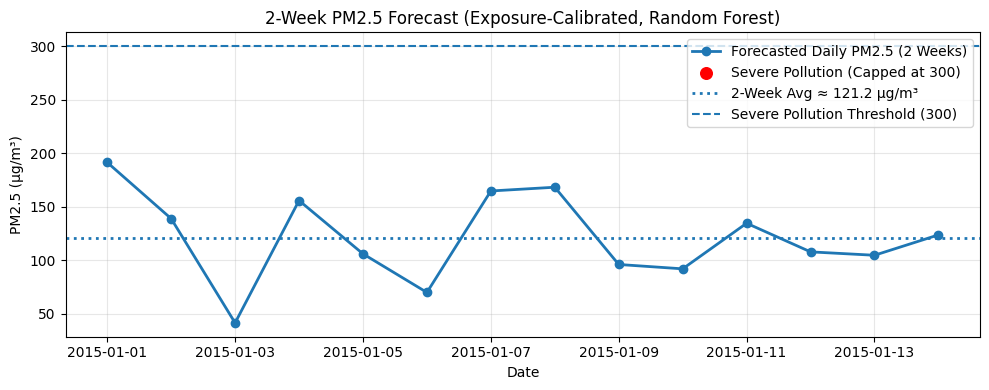

In [14]:
plt.figure(figsize=(10, 4))

plt.plot(
    forecast_2w["date"],
    forecast_2w["predicted_pm2.5_final"],
    marker="o",
    linewidth=2,
    label="Forecasted Daily PM2.5 (2 Weeks)"
)

# Highlight saturated (severe) days
sat_days = forecast_2w[forecast_2w["saturated"]]
plt.scatter(
    sat_days["date"],
    sat_days["predicted_pm2.5_final"],
    color="red",
    s=70,
    label="Severe Pollution (Capped at 300)"
)

plt.axhline(
    forecast_2w_avg_final,
    linestyle=":",
    linewidth=2,
    label=f"2-Week Avg ≈ {forecast_2w_avg_final:.1f} µg/m³"
)

plt.axhline(
    300,
    linestyle="--",
    linewidth=1.5,
    label="Severe Pollution Threshold (300)"
)

plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("2-Week PM2.5 Forecast (Exposure-Calibrated, Random Forest)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
